In [1]:
from brian2 import *
from brian2tools import *

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from plotting_helper import * 

figures_path = 'figures/'
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']  

####look at the data LTP/LTD ratio and the shape

def LTP_LTD_ratio(kernel):
    
    
    total_int = np.sum(np.abs(kernel))
    
    LTP_mask = 1.0*(kernel > 0)
    LTD_mask = 1.0*(kernel<0)
    
    LTP_perc = np.sum(kernel*LTP_mask)/total_int
    LTD_perc = np.sum(kernel*LTD_mask)/total_int #negative value anyway
    
    return LTP_perc+LTD_perc    

def symmetry_kernel(kernel):
    
    #just estimates if the kernel is point (causal/anti-causal) or axis symmetric (coincidence/ correlation)
    #does not take into account the actual values, just if it positive and negative outweighs each other
    #relative to the y-axis
    
    if kernel.shape[0] % 2 == 0: 
        midpoint = int(kernel.shape[0]/2)
    else: 
        midpoint = int((kernel.shape[0]-1)/2)
        
    norm_quotient = np.sum(np.abs(kernel))
      
    symmetry_score = 0
    
    for i in range(midpoint): 
        symmetry_score += (kernel[-i]-kernel[i])
      
    #normalizing with the total sum of the kernel area
    symmetry_score = symmetry_score * 1/norm_quotient
    #is 1 for hebbian kernel, 0 for symmetric kernel, -1 for anti-hebbian kernel  
    
    return symmetry_score


    


In [2]:
%colors nocolor


# helper for half_wave rectification
@check_units(x=1, result=1)
def rect(x): 
    return x * int(x > 0)

@check_units(x=1, theta=1, v=1, result=1)
def sig(x, theta, v): 
    return 1/(1+exp(v*(-x+theta)))
    
@check_units(x=1, v=1, result=1)
def pot_fun(x): 
    k = exp(-2.5)*20
    return x**k

# VDP parameters
##########################################

act_offset = 0
tau_Ca = 1 * ms
fun_CA = pot_fun
c_ca = 2.5
tau_w = 1 * ms
#eta = 100  to make it easier to fit to data this will be optimized as well

vrest = -79 * mV
wmin = 0
wmax = 2

#for neuron model
tau_mem_LIF = 10*ms
LIF_amp = 500 * mV


# VDP equations
##########################################

VDP_eq = '''
    dglutamate/dt = - glutamate/tau_glutamate : 1 (clock-driven)
    sig_LTP = 1/(1+exp(k_LTP*(-(v - theta_NMDA)+0*mV))) : 1 (constant over dt)
    dv_NMDA_rise/dt = (-v_NMDA_rise + clip(clip(sig_LTP - v_NMDA,0,100) - v_NMDA_rise,0,100))/tau_NMDA_rise : 1 (clock-driven)             
    dv_NMDA/dt = (NMDA_amp * v_NMDA_rise - v_NMDA)/tau_NMDA_fall : 1 (clock-driven)
    sig_LTD = 1/(1+exp(k_LTD*(-(v - theta_VDCC)+0*mV))) : 1 (constant over dt)
    dVDCC_rise/dt = (-VDCC_rise + clip(clip(sig_LTD - VDCC,0,100) -VDCC_rise, 0, 100))/tau_VDCC_rise : 1 (clock-driven) 
    dVDCC/dt = (VDCC_amp * VDCC_rise - VDCC) * 1/tau_VDCC_fall : 1 (clock-driven)
    Ca = VDCC**(exp(-c_ca)*20) + v_NMDA**(exp(-c_ca)*20) * int(glutamate>0) : 1 (constant over dt)
    dw/dt = clip(eta * Ca  * (v_NMDA * LTP_amp - VDCC * LTD_amp) * glutamate/tau_w*dt,(wmin-w),(wmax-w))/dt : 1 (clock-driven)
    tau_glutamate :second
    theta_NMDA : volt
    tau_NMDA_rise : second
    tau_NMDA_fall : second
    NMDA_amp : 1
    theta_VDCC : volt
    tau_VDCC_rise : second
    tau_VDCC_fall : second
    VDCC_amp : 1
    k_LTP : 1/volt
    k_LTD : 1/volt
    LTP_amp : 1
    LTD_amp : 1
    Apre : 1  #this is technically decided by tau_glutamate but just adding it here for completeness sake
    eta : 1
'''

eonpre ='''
    glutamate += Apre
'''

LIF_eqs = '''
    dv/dt = (vrest-v)/tau + I_stim(t,i)/tau: volt (unless refractory)
    tau : second
'''

LIF_reset = '''
    v = -79*mV
'''

In [3]:
def unpack_synparams(Syn, params): 
    Syn.Apre = params[0] 
    Syn.tau_glutamate = params[1] *ms
    
    Syn.k_LTD = params[2] /mV 
    LTD_rise = params[3]
    LTD_fall = params[4]
    LTP_rise = params[8]
    LTP_fall = params[9]
    Syn.tau_VDCC_rise = LTD_rise * ms
    Syn.tau_VDCC_fall = LTD_fall * ms
    Syn.theta_VDCC  = params[5] * mV
    Syn.LTD_amp = params[6]
    
    Syn.k_LTP = params[7] / mV
    Syn.tau_NMDA_rise = LTP_rise * ms
    Syn.tau_NMDA_fall =  LTP_fall * ms
    Syn.theta_NMDA = params[10] * mV
    Syn.LTP_amp = params[11]
    Syn.eta = params[12]

    
    #predetermined by time constants
    Syn.NMDA_amp = (LTP_rise/LTP_fall)**(LTP_fall/(LTP_rise - LTP_fall))
    Syn.VDCC_amp = (LTD_rise/LTD_fall)**(LTD_fall/(LTD_rise - LTD_fall))
    
    return Syn

def STDP_fun(GE, syn_params, I_amp, stdp_delays): 
    
    start_scope()
    N = int(stdp_delays.shape[0])
    w0 = 1
    

    pre_time = 200
    pre_spikes = np.zeros(N, dtype = 'int')
    for post_ind, post in enumerate(stdp_delays): 
        pre_spikes[post_ind] = pre_time
        
    IG_E = SpikeGeneratorGroup(N, np.arange(N), pre_spikes*ms)

    # Synapses
    ##########################################
    S_IG_E = Synapses(IG_E, GE, VDP_eq,on_pre=eonpre,method='euler')
    S_IG_E.connect(condition='i == j')
    
    S_IG_E = unpack_synparams(S_IG_E, syn_params)
    S_IG_E.w = w0
    
    # Monitors
    ##########################################

    M_IG_E_w = StateMonitor(S_IG_E, ['w'], record=True, dt=.1 * ms)
    spike_mon = SpikeMonitor(GE)
    v_monitor = StateMonitor(GE, ['v'], record = True, dt = .1* ms)
    
    net = Network(GE, IG_E, S_IG_E, spike_mon, v_monitor, M_IG_E_w)
    net.store()

    ##########################################

    I_stim_duration = 1 
    
    post_stims = np.zeros((1000, N))*I_amp
    for ind, stdp_dt in enumerate(stdp_delays):
            post_stims[pre_time+int(stdp_dt):pre_time+I_stim_duration+int(stdp_dt), ind] = I_amp
    I_stim = TimedArray(post_stims, dt=1*ms)

    net.run(1000*ms)

        
    perc_w = (M_IG_E_w.w[:,-1] - w0)/w0 * 100 + 100
    return perc_w, spike_mon.t, v_monitor


In [4]:
###############  
#all different STDP kernel forms
#with shape and ratio measurement
rs = np.zeros(4)
ss = np.zeros(4)
stdp_dts = np.arange(-50, 50, 1)
N = stdp_dts.shape[0]

LIF_neuron = NeuronGroup(N, LIF_eqs, threshold='v > -49 *mV', method='euler', reset=LIF_reset, refractory = 3 * ms)
LIF_neuron.tau = tau_mem_LIF
LIF_neuron.v = -79 * mV
lif_params = [0.1, 10, 0.4, 1, 20, -43.75, 0.18, 0.4, 1, 5, -40.75, 1.0, 1e5]
LIF_res, LIF_spikes, LIF_v = STDP_fun(LIF_neuron, lif_params, LIF_amp, stdp_dts)

rs[0] = LTP_LTD_ratio(LIF_res-100)
ss[0] = symmetry_kernel(LIF_res-100)

LIF_amp = 500 * mV

LIF_neuron = NeuronGroup(N, LIF_eqs, threshold='v > -49 *mV', method='euler', reset=LIF_reset, refractory = 3 * ms)
LIF_neuron.tau = tau_mem_LIF
LIF_neuron.v = -79 * mV
lif_params = [0.1, 10, 0.4, 1, 5, -43.75, 0.42, 0.4, 1, 20, -40.75, 1.0, 2e5]
anti_hebb_STDP, LIF_spikes, LIF_v = STDP_fun(LIF_neuron, lif_params, LIF_amp, stdp_dts)
rs[1] = LTP_LTD_ratio(anti_hebb_STDP-100)
ss[1] = symmetry_kernel(anti_hebb_STDP-100)

#this is the LTD overstimulated
LIF_neuron = NeuronGroup(N, LIF_eqs, threshold='v > -49 *mV', method='euler', reset=LIF_reset, refractory = 3 * ms)
LIF_neuron.tau = tau_mem_LIF
LIF_neuron.v = -79 * mV
lif_params = [0.1, 10, 0.4, 1, 20, -43.75, 0.4, 0.4, 1, 10, -40.75, 1.0, 5e4]
LTP_STDP, LIF_spikes, LIF_v = STDP_fun(LIF_neuron, lif_params, LIF_amp, stdp_dts)
rs[2] = LTP_LTD_ratio(LTP_STDP-100)
ss[2] = symmetry_kernel(LTP_STDP-100)


#this is the LTP overstimulted kernel
LIF_neuron = NeuronGroup(N, LIF_eqs, threshold='v > -49 *mV', method='euler', reset=LIF_reset, refractory = 3 * ms)
LIF_neuron.tau = tau_mem_LIF
LIF_neuron.v = -79 * mV
lif_params = [0.1, 10, 0.4, 1, 10, -43.75, 0.2, 0.4, 1, 20, -40.75, 1.0, 5e4]
LTD_STDP, LIF_spikes, LIF_v = STDP_fun(LIF_neuron, lif_params, LIF_amp, stdp_dts)
rs[3] = LTP_LTD_ratio(LTD_STDP-100)
ss[3] = symmetry_kernel(LTD_STDP-100)

print(rs)
print(ss)

[-3.22467793e-05 -7.92130618e-02 -1.00000000e+00  1.00000000e+00]
[ 0.77410351 -0.80165911  0.26943529 -0.03173653]


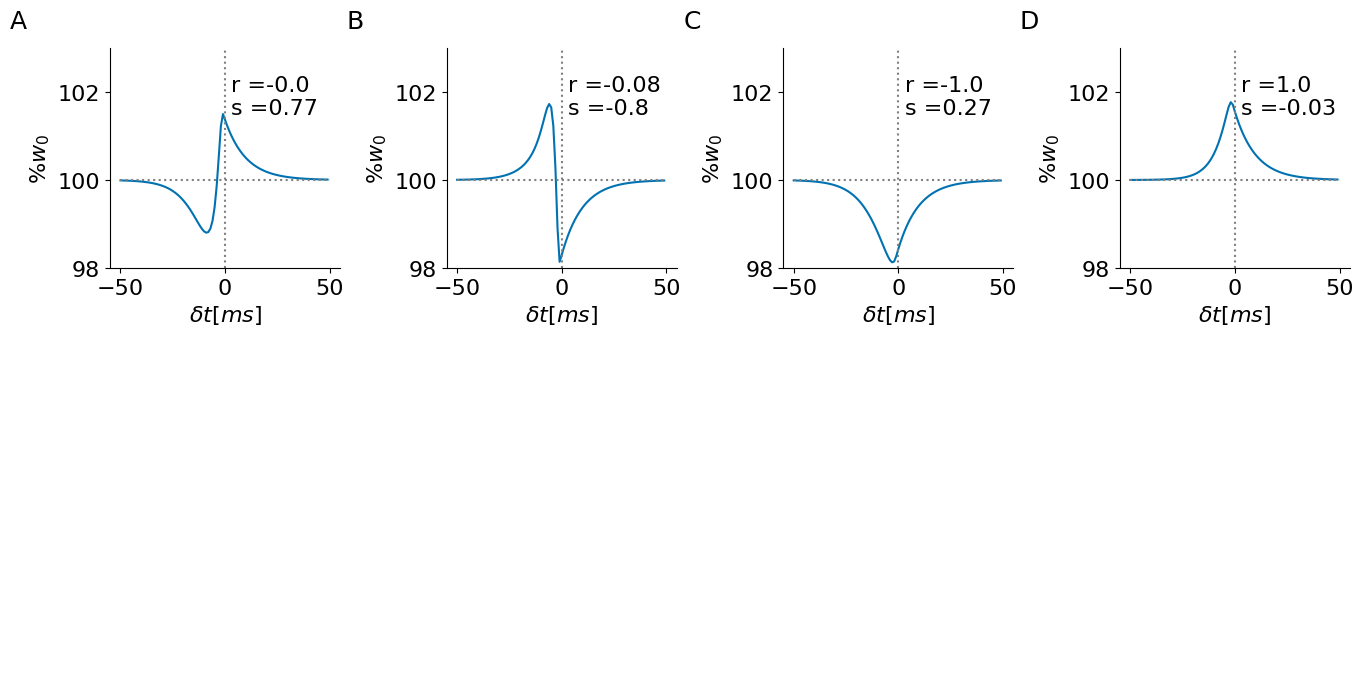

In [5]:
      
layout = '''
    AABBCCD
    AABBCCD
    '''

fig = plt.figure(figsize=(16, 8))

height_ratios = [1.0, 1.0]
width_ratios = [1,.2, 1,.2, 1,.2, 1]

specs, gs = panel_specs(layout, fig=fig)
gs.set_height_ratios(height_ratios)
gs.set_width_ratios(width_ratios)
gs.hspace=0.8
axes = {}
for letter in 'ABCD':
    axes[letter] = ax = fig.add_subplot(specs[letter])
label_panels(axes, letters='ABCD', postfix='', offset_left=1)
for a in list('ABCD'):
    axes[a].set_axis_off()
    
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']  

#plot LIF w
ax = fig.add_subplot(gs[0,0])
ax.plot(stdp_dts, LIF_res)
ax.set_ylim(98, 103)
minimum, maximum = ax.get_ylim()
ax.plot([0,0],[minimum, maximum], color = 'grey', linestyle = ':')
ax.plot([-50,50],[100,100], color = 'grey', linestyle = ':')
ax.ticklabel_format(useOffset=False, style = 'plain')
ax.set_xlabel('$\delta t [ms]$')
ax.set_ylabel('$\% w_{0}$')
ax.text(3,101.5, 'r ='+str(np.round(rs[0],2))+'\ns ='+str(np.round(ss[0],2)), fontsize = 16)
ax.ticklabel_format(useOffset=False, style = 'plain')
clear_axes(ax)

#plot LIF w
ax = fig.add_subplot(gs[0,2])
ax.plot(stdp_dts, anti_hebb_STDP)
ax.set_ylim(98, 103)
minimum, maximum = ax.get_ylim()
ax.plot([0,0],[minimum, maximum], color = 'grey', linestyle = ':')
ax.plot([-50,50],[100,100], color = 'grey', linestyle = ':')

ax.ticklabel_format(useOffset=False, style = 'plain')
ax.set_xlabel('$\delta t [ms]$')
ax.set_ylabel('$\% w_{0}$')
ax.text(3,101.5, 'r ='+str(np.round(rs[1],2))+'\ns ='+str(np.round(ss[1],2)), fontsize = 16)
ax.ticklabel_format(useOffset=False, style = 'plain')
clear_axes(ax)

#plot LIF w
ax = fig.add_subplot(gs[0,4])
ax.plot(stdp_dts, LTP_STDP)
ax.set_ylim(98, 103)
minimum, maximum = ax.get_ylim()
ax.plot([0,0],[minimum, maximum], color = 'grey', linestyle = ':')
ax.plot([-50,50],[100,100], color = 'grey', linestyle = ':')

ax.ticklabel_format(useOffset=False, style = 'plain')
ax.set_xlabel('$\delta t [ms]$')
ax.set_ylabel('$\% w_{0}$')
ax.text(3,101.5, 'r ='+str(np.round(rs[2],2))+'\ns ='+str(np.round(ss[2],2)), fontsize = 16)
ax.ticklabel_format(useOffset=False, style = 'plain')
clear_axes(ax)

#plot LIF w
ax = fig.add_subplot(gs[0,6])
ax.plot(stdp_dts, LTD_STDP)
ax.set_ylim(98, 103)
minimum, maximum = ax.get_ylim()
ax.plot([0,0],[minimum, maximum], color = 'grey', linestyle = ':')
ax.plot([-50,50],[100,100], color = 'grey', linestyle = ':')

ax.ticklabel_format(useOffset=False, style = 'plain')
ax.set_xlabel('$\delta t [ms]$')
ax.set_ylabel('$\% w_{0}$')
ax.text(3,101.5, 'r ='+str(np.round(rs[3],2))+'\ns ='+str(np.round(ss[3],2)), fontsize = 16)
ax.ticklabel_format(useOffset=False, style = 'plain')
clear_axes(ax)

#plt.savefig(figures_path+'appendix_fig3_stdp_kernels.pdf', bbox_inches='tight')

plt.show()
